## 1. EDA bộ dataset

- Hiển thị được phân phối class của tập train/test
- Thông kê được tổng số dữ liệu, tổng số class

In [2]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms

# Load FashionMNIST dataset

transform = torchvision.transforms.ToTensor()  # You can add more transformations if needed
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [3]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
# Class labels
class_labels = trainset.classes

# Basic statistics
num_train_samples = len(trainset)
num_test_samples = len(testset)
num_classes = len(class_labels)

print("Number of training samples:", num_train_samples)
print("Number of test samples:", num_test_samples)
print("Number of classes:", num_classes)
# Print image size
sample_image, _ = next(iter(trainset))
print("Image size:",sample_image.shape)

Number of training samples: 60000
Number of test samples: 10000
Number of classes: 10
Image size: torch.Size([1, 28, 28])


In [5]:
# 1x28x28 -> 1x784

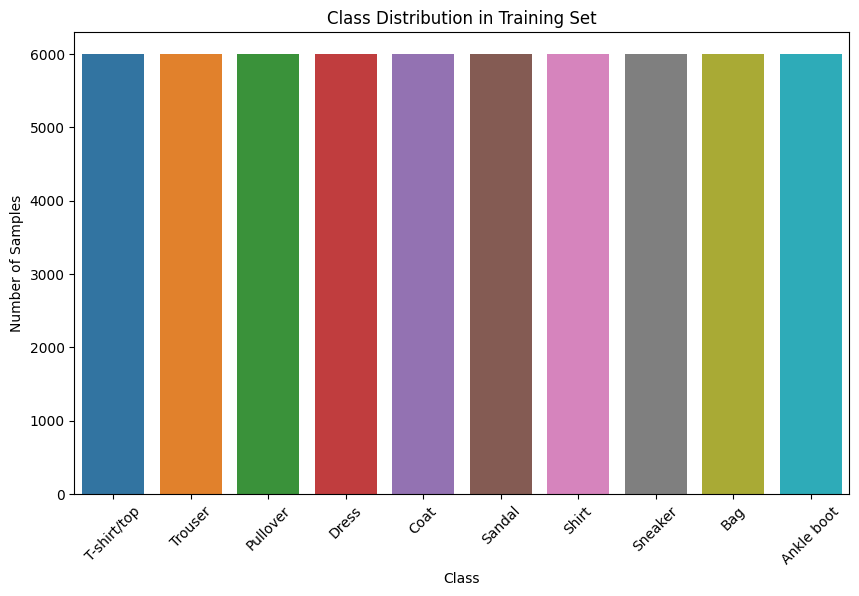

In [6]:
# Class distribution in training set
train_class_distribution = np.bincount(trainset.targets)
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=train_class_distribution)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

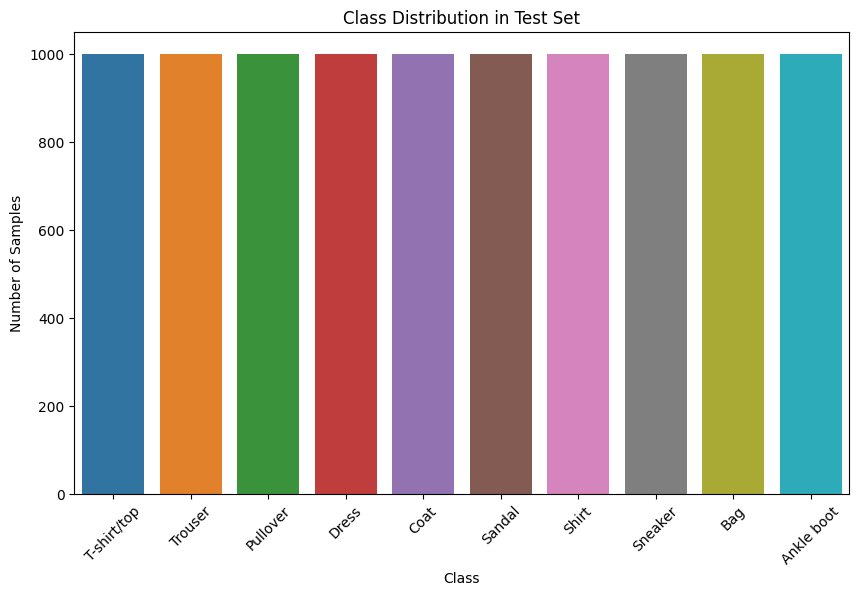

In [7]:
# Class distribution in test set
test_class_distribution = np.bincount(testset.targets)
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=test_class_distribution)
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

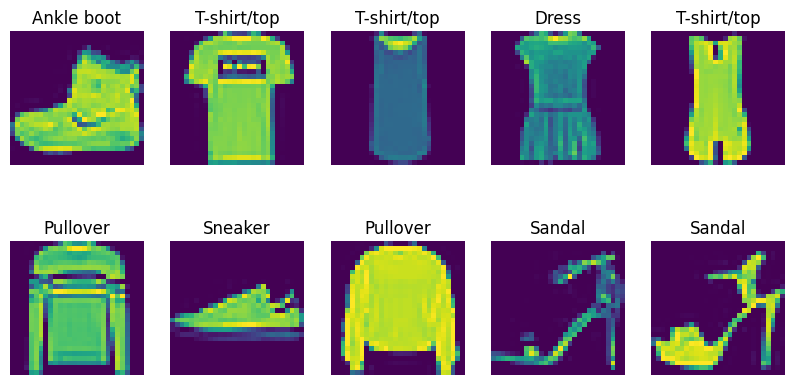

In [8]:
# Display sample images from training set
plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    img, label = trainset[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Transpose to (H, W, C) format
    plt.imshow(img)
    plt.title(class_labels[label])
    plt.axis('off')
plt.show()

## 2. Modeling

In [9]:
import torch
import torch.nn as nn

### Define model simple

In [10]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout_p, activation):
        super(CustomNN, self).__init__()

        self.layers = nn.ModuleList()  # List to hold the layers

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(activation)
        self.layers.append(nn.Dropout(p=dropout_p))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(activation)
            self.layers.append(nn.Dropout(p=dropout_p))

        # Output layer
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Testing model

In [11]:
# Testing model
input_size = 784
hidden_layers = [256, 128]
output_size = 10
dropout_p = 0.2
activation = nn.ReLU()

model = CustomNN(input_size, hidden_layers, output_size, dropout_p, activation)
print(model)

CustomNN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 3. Training model

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

### Configs model

## Batching data + convert được data sang tensor

In [37]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 40
BATCH_SIZE = 256  # You can adjust this based on your needs
# Create data loaders
TRAINLOADER = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

### Define optimizer, init model
``` python
# Optimizer dictionary
'SGD': optim.SGD(model.parameters(), lr=0.001),
'Momentum': optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
'Adam': optim.Adam(model.parameters(), lr=0.001),


# Learning rate schedulers dictionary
'Step Decay': StepLR(optimizer, step_size=30, gamma=0.5),
'Exponential Decay': ExponentialLR(optimizer, gamma=0.95),
'Cosine Annealing': CosineAnnealingLR(optimizer, T_max=5),


```

In [48]:
# Init Model
input_size = 28*28  # image size
hidden_layers = [ 256, 128, 64]
output_size = 10
dropout_p = 0.2
activation = nn.ReLU()
model = CustomNN(input_size, hidden_layers, output_size, dropout_p, activation)

# Chuyển model lên cuda
model.to(DEVICE)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.005)# Choose the optimizer
# scheduler = CosineAnnealingLR(optimizer, T_max=5)  # Choose the scheduler
scheduler = None


In [49]:
loss_train = []
loss_test = []
f1_train = []
f1_test = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    predictions_train = []
    true_labels_train = []
    for i, data in enumerate(TRAINLOADER, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs =  model(inputs.view(-1, input_size))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predictions_train.extend(predicted.tolist())
        true_labels_train.extend(labels.tolist())
    if scheduler is not None:
        scheduler.step()  # Update learning rate with scheduler
    train_loss = running_loss / len(TRAINLOADER)
    train_f1 = f1_score(true_labels_train, predictions_train, average='weighted')

    loss_train.append(train_loss)
    f1_train.append(train_f1)

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss_val = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in TESTLOADER:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs.view(-1, input_size))
            #outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    test_loss_val /= len(TESTLOADER)
    test_f1_val = f1_score(true_labels, predictions, average='weighted')

    loss_test.append(test_loss_val)
    f1_test.append(test_f1_val)
    print(f'Epoch [{epoch + 1}/{EPOCHS}]  - Train Loss: {train_loss:.4f} - Train F1: {train_f1:.4f} - Test Loss: {test_loss_val:.4f} - Test F1: {test_f1_val:.4f}')

print('Finished Training')

Epoch [1/40]  - Train Loss: 0.6325 - Train F1: 0.7660 - Test Loss: 0.4688 - Test F1: 0.8234
Epoch [2/40]  - Train Loss: 0.4483 - Train F1: 0.8401 - Test Loss: 0.4124 - Test F1: 0.8455
Epoch [3/40]  - Train Loss: 0.4091 - Train F1: 0.8510 - Test Loss: 0.3821 - Test F1: 0.8582
Epoch [4/40]  - Train Loss: 0.3956 - Train F1: 0.8566 - Test Loss: 0.3986 - Test F1: 0.8540
Epoch [5/40]  - Train Loss: 0.3810 - Train F1: 0.8639 - Test Loss: 0.3741 - Test F1: 0.8667
Epoch [6/40]  - Train Loss: 0.3714 - Train F1: 0.8643 - Test Loss: 0.3896 - Test F1: 0.8430
Epoch [7/40]  - Train Loss: 0.3640 - Train F1: 0.8663 - Test Loss: 0.3767 - Test F1: 0.8675
Epoch [8/40]  - Train Loss: 0.3609 - Train F1: 0.8681 - Test Loss: 0.3802 - Test F1: 0.8489
Epoch [9/40]  - Train Loss: 0.3521 - Train F1: 0.8724 - Test Loss: 0.3704 - Test F1: 0.8634
Epoch [10/40]  - Train Loss: 0.3486 - Train F1: 0.8745 - Test Loss: 0.3473 - Test F1: 0.8715
Epoch [11/40]  - Train Loss: 0.3419 - Train F1: 0.8761 - Test Loss: 0.3592 - Te

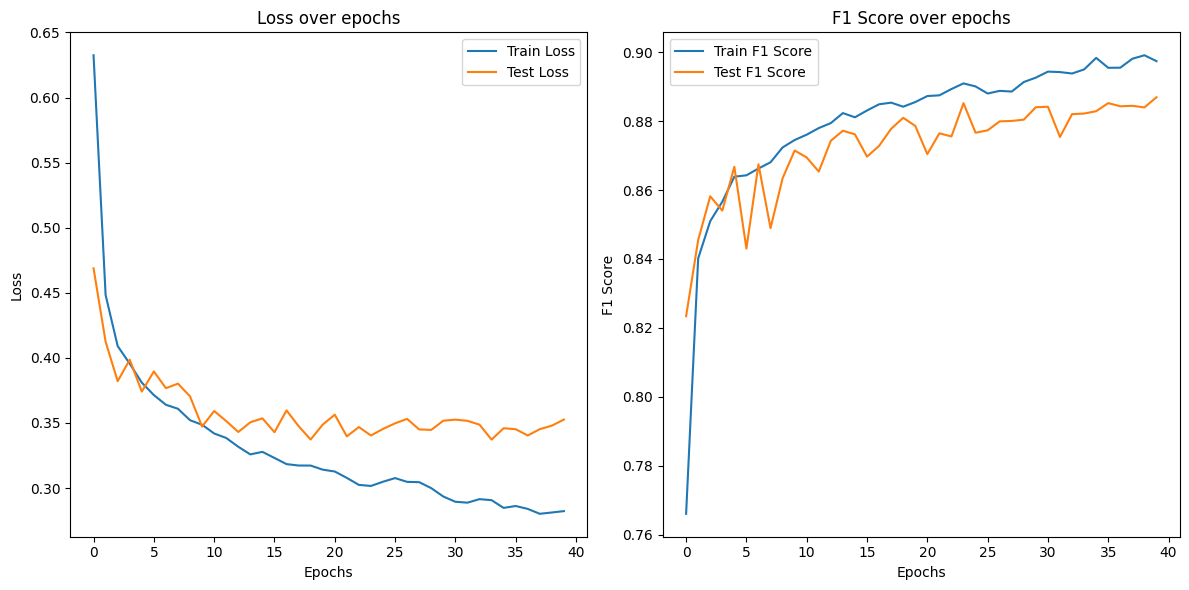

In [50]:
# Plotting the metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_test, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_train, label='Train F1 Score')
plt.plot(f1_test, label='Test F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluation model

In [51]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns


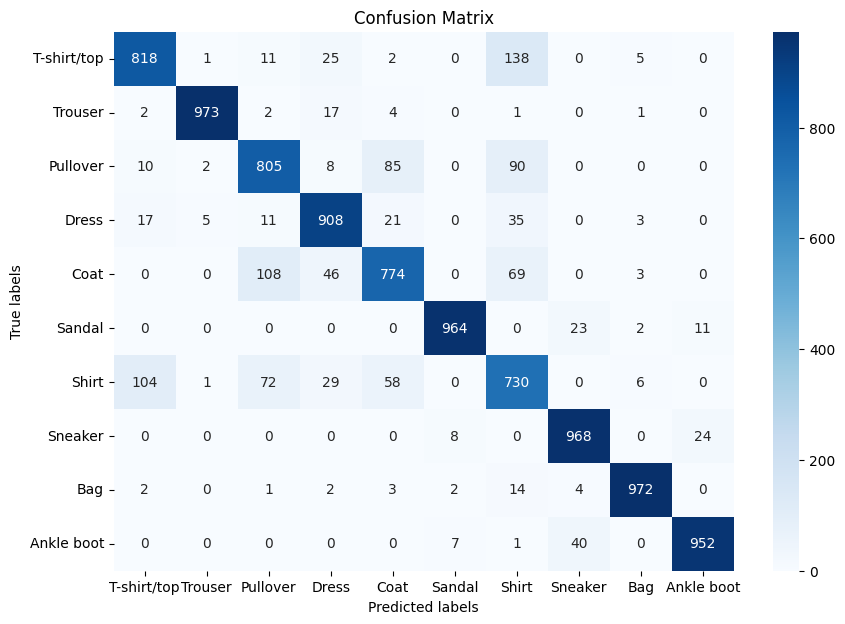

In [52]:
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for data in TESTLOADER:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs.view(-1, input_size))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().tolist())
        all_true_labels.extend(labels.cpu().tolist())


# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [53]:
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("Weighted F1 Score:", f1)

Weighted F1 Score: 0.8869297734288981


In [54]:
print(classification_report(all_true_labels, all_predictions, target_names=class_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.82      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.81      0.80      1000
       Dress       0.88      0.91      0.89      1000
        Coat       0.82      0.77      0.80      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.68      0.73      0.70      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## 5. Practices
Hãy thử làm mọi cách để f1_score trên tập test đạt >= 87%
- Thử thay bằng model có độ phức tạp hơn
- Dùng optimizer khác, scheduler khác
- Dùng hàm activate_function khác ReLU, LeakyReLU
- Thử tăng hoặc giảm Learning rate, Batch_size
